<a href="https://colab.research.google.com/github/Arun-Pat/MLZoomCamp_AP/blob/main/MLZoomCamp_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# **Homework**
Note: sometimes your answer doesn't match one of the options exactly. That's fine. Select the option that's closest to your solution.

In this homework, we will use the Car price dataset like last week. Download it from here.

Or you can do it with wget:

wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
We'll work with the MSRP variable, and we'll transform it to a classification task.

For the rest of the homework, you'll need to use only these columns:

Make,
Model,
Year,
Engine HP,
Engine Cylinders,
Transmission Type,
Vehicle Style,
highway MPG,
city mpg
MSRP

In [ ]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'
!wget $url -O car_data.csv


--2023-10-06 16:44:02--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘car_data.csv’

car_data.csv        100%[===================>]   1.41M  --.-KB/s    in 0.04s   

2023-10-06 16:44:02 (33.2 MB/s) - ‘car_data.csv’ saved [1475504/1475504]



In [ ]:
df = pd.read_csv('car_data.csv')
df.orig = df.copy()
column_list = ['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders', 'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg','MSRP']
df = df[column_list]
df.head()

<ipython-input-263-9c325ddcd92e>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.orig = df.copy()


,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


# **Data preparation**
- Keep only the columns above
- Lowercase the column names and replace spaces with underscores
- Fill the missing values with 0
- Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable above_average
- Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [ ]:
df.columns = df.columns.str.replace(' ','_').str.lower()
df.rename(columns = {'msrp':'price'}, inplace = True)
df = df.fillna(0)

price_mean = df.price.mean()
above_average_all = (df.price > price_mean).astype(int)


In [ ]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, train_size=0.8, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, train_size=0.75, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

above_average_train = (df_train.price > price_mean).astype(int)
above_average_val = (df_val.price > price_mean).astype(int)
above_average_test = (df_test.price > price_mean).astype(int)

del df_train['price']
del df_val['price']
del df_test['price']

# len(df),len(df_full_train),len(df_train),len(df_val),len(df_test)


# **Question 1: ROC AUC feature importance**
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score and compute AUC with the above_average variable
- Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- engine_hp         0.917  ✅
- engine_cylinders  0.766
- highway_mpg       0.633
- city_mpg          0.673


     year, 0.688
engine_hp, 0.917
engine_cylinders, 0.766
highway_mpg, 0.633
 city_mpg, 0.673

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [ ]:
# Other way to get categoty and numerical columns
# a = list (df_train.columns[df_train.dtypes == object])
# b = list (df_train.columns[df_train.dtypes != object])

categorical = list (df.dtypes[df.dtypes == object].index)
numerical = list (df.dtypes[(df.dtypes.index != 'price') & (df.dtypes != object)].index)

numerical

['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [ ]:
#@ CALCULATING ROC AUC SCORE:
for feat in numerical:
    auc_score = roc_auc_score(above_average_train, df_train[feat])
    if auc_score < 0.5:
        auc_score = roc_auc_score(above_average_train, -df_train[feat])
    print(f'{feat} - auc: {round(auc_score,3)}')

year - auc: 0.688
engine_hp - auc: 0.917
engine_cylinders - auc: 0.766
highway_mpg - auc: 0.633
city_mpg - auc: 0.673


In [ ]:
len(df_train.year), len(above_average_train)

(7148, 7148)

In [ ]:
# for feat in numerical:
#   X_train = df_train[feat].to_numpy().reshape(-1, 1)
#   X_val = df_val[feat].to_numpy().reshape(-1, 1)

#   model = LogisticRegression()
#   model.fit( X_train,above_average_train )

#   y_pred = model.predict_proba(X_val)[:, 1]
#   # y_pred = model.predict_proba(X_val)[:, 1]
#   # churn_decision = (y_pred >= 0.5)
#   # (y_val == churn_decision).mean()
#   fpr, tpr, thresholds = roc_curve(above_average_val, y_pred)
#   s = auc(fpr, tpr)
#   print(f'{feat}: auc: {s}')


# **Question 2: Training the model**
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979 ✅

In [ ]:
from sklearn.feature_extraction import DictVectorizer

In [ ]:
# One hot coding
dv= DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical+numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)


In [ ]:
#Logistic Regression Model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, above_average_train)

y_pred = model.predict_proba(X_val)[:, 1]

roc_auc_score(above_average_val, y_pred)

0.9797482414575607

In [ ]:
fpr, tpr, thresholds = roc_curve(above_average_val, y_pred)
auc(fpr, tpr)


0.9797482414575607

# **Question 3: Precision and Recall**
Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

- 0.28
- 0.48 ✅
- 0.68
- 0.88

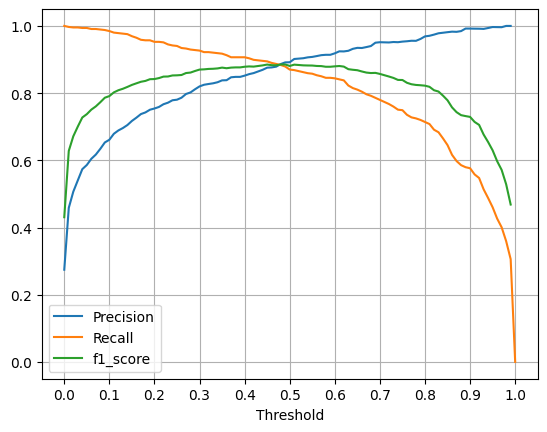

In [ ]:
y_val = above_average_val

scores = []

thresholds = np.arange(0, 1.01, .01)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

df_scores['f1_score'] = 2* (df_scores.precision*df_scores.recall / (df_scores.precision + df_scores.recall))
# df_scores[df_scores['f1_score'] == df_scores['f1_score'].max()]


plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')

plt.plot(df_scores.threshold, df_scores['f1_score'], label='f1_score')

plt.legend()
plt.xlabel("Threshold")
pltarray = np.arange(0,1.1,.1)
plt.xticks(pltarray)
plt.grid(which ='both', axis='both')




# **Question 4: F1 score**
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

 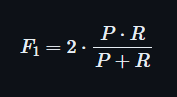

Where
 is precision and
 is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52 ✅
- 0.72

In [ ]:
# df_scores['f1_score'] = 2* (df_scores.precision*df_scores.recall / (df_scores.precision + df_scores.recall))
# df_scores['f1_score'].max()
df_scores[df_scores['f1_score'] == df_scores['f1_score'].max()]

,threshold,tp,fp,fn,tn,precision,recall,f1_score
49,0.49,575,70,79,1659,0.891473,0.879205,0.885296


# **Question 5: 5-Fold CV**
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- 0.003 ✅
- 0.030
- 0.090
- 0.140

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, solver='liblinear',max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [ ]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [ ]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    C = 1.0
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        # y_train = df_train.price.values
        # y_val = df_val.price.values

        y_train = (df_train.price > price_mean).astype(int)
        y_val = (df_val.price > price_mean).astype(int)

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        print(f'auc={auc}')

    print('\nmean auc %.3f stdv +- %.3f' % (np.mean(scores), np.std(scores)))

auc=0.9784891235596622
auc=0.9802029731275015
auc=0.9829025151971447
auc=0.9772586581897273
auc=0.9776862026862028

mean auc 0.979 stdv +- 0.002


# **Question 6: Hyperparemeter Tuning**

Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.01, 0.1, 0.5, 10]
- Initialize KFold with the same parameters as previously
- Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
Which C leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10  ✅

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.


In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
C_values = [0.01, 0.1, 0.5, 10]
scores = []

for C in  C_values:
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        # y_train = df_train.price.values
        # y_val = df_val.price.values

        y_train = (df_train.price > price_mean).astype(int)
        y_val = (df_val.price > price_mean).astype(int)

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('\nC=%s mean auc %.3f stdv +- %.3f' % (C,np.mean(scores), np.std(scores)))


C=0.01 mean auc 0.952 stdv +- 0.003

C=0.1 mean auc 0.962 stdv +- 0.010

C=0.5 mean auc 0.967 stdv +- 0.011

C=10 mean auc 0.970 stdv +- 0.012
